# Statistical Learning - Classification

---

## Contents

### [Why Not Linear Regression?](#whynot)
### [Logistic Regression](#logistic-regression)
   - [The Logistic Model](#logistic-model)
   - [Estimating the Regression Coefficients](#estimating-coefficients)
   - [Making Predictions](#making-predictions)
   - [Multiple Logistic Regression](#multiple-logistic-regression)
   

### [Linear Discriminant Analysis](#lda)
   - [Using Bayes' Theorem for Classification](#lda-bayes)
   - [Linear Discriminant Analysis for $p=1$](#lda-simple)
   - [Linear Discriminant Analysis for $p>1$](#lda-multiple)
   - [Quadratic Discriminant Analysis](#qda)
   

### [A Comparison of Classification Methods](#comparison)


### [Lab](#lab)

---

## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as mpe
import seaborn as sns

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import zero_one_loss, precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc

import statsmodels.api as sm
import statsmodels.formula.api as smf

np.set_printoptions(suppress=True)
%matplotlib inline
plt.style.use("fivethirtyeight")

---

## Utilities

In [2]:
def pretty_cm(y_true, y_pred, classes):
    counts = confusion_matrix(y_true = y_true,
                              y_pred = y_pred,
                              labels = classes).T
    df = pd.DataFrame(counts, index = classes, columns = classes)
    df.loc["Total"] = df.sum(numeric_only = True, axis = 0)
    df.loc[:, "Total"] = df.sum(numeric_only = True, axis = 1)
    df = pd.concat({"Predicted": df})
    df.columns = pd.MultiIndex.from_product([["True"], df.columns])
    return df

In [3]:
def get_best_roc_threshold(model, y_true):
    report = {class_name: dict() for class_name in model.classes_}
    
    for class_idx, class_name in enumerate(model.classes_):
        fpr, tpr, thresholds = roc_curve(y_true = Y, y_score = model.predict_proba(X)[:, class_idx], pos_label = class_name)
        best_idx = np.argmax(np.sqrt(tpr * (1 - fpr)))
        report[class_name]["threshold"] = thresholds[best_idx]
        report[class_name]["tpr"] = tpr[best_idx]
        report[class_name]["fpr"] = fpr[best_idx]
        report[class_name]["auc"] = auc(fpr, tpr)
        
        fig, ax = plt.subplots(figsize = (8, 4))
        line_edge = [mpe.Stroke(linewidth = 8, foreground= "k"), mpe.Normal()]
        ax.plot(fpr, tpr, path_effects = line_edge)
        ax.scatter(fpr[best_idx], tpr[best_idx], s = 500, edgecolor = "k", lw = 2, color = "coral")
        tx = f"Threshold: {round(thresholds[best_idx], 2)}\nTPR: {round(tpr[best_idx], 2)}\nFPR: {round(fpr[best_idx], 2)}"
        ax.annotate(tx, xy = (0.75, 0.2))
        ax.set_ylabel(f"True Positive Rate")
        ax.set_xlabel(f"False Positive Rate (class = {class_name})")
    return report

In [4]:
def plot_2d_decbound(X1, X2, Y, model, figsize = (8, 4)):
    fig, ax = plt.subplots(figsize = figsize)
    palette = ["cornflowerblue", "coral", "palegreen"]
    x_min, x_max = np.array(X1).min() - 1, np.array(X1).max() + 1
    y_min, y_max = np.array(X2).min() - 1, np.array(X2).max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    plt.contourf(xx, yy, z, cmap = "coolwarm", alpha = 0.5)
    sns.scatterplot(x = np.array(X1), y = np.array(X2),
                    hue = Y,
                    palette = palette[:len(Y.unique())],
                    edgecolor = "k", linewidth = 1.5, s = 100)
    plt.legend(loc = 1, edgecolor = "k",
               facecolor = "lightgrey", prop = {"size": 14})
    plt.grid(True)
    plt.show()

In [5]:
def rates(y_true, y_pred, classes):
    report = pd.DataFrame({class_name: {"TPR - Sensitivity": None,
                                        "TNR - Specificity": None,
                                        "FPR - Fallout": None,
                                        "FNR - Miss Rate": None} for class_name in classes})
    df = pd.DataFrame({"y_true": y_true, "y_pred": y_pred})
    
    for class_name in classes:
        pos = df[df.y_true == class_name]
        neg = df[df.y_true != class_name]
        tp = np.sum(pos.y_pred == class_name)
        tn = np.sum(neg.y_pred != class_name)
        fp = np.sum(neg.y_pred == class_name)
        fn = np.sum(pos.y_pred != class_name)
        report.loc["TPR - Sensitivity"][class_name] = tp / (tp + fn)
        report.loc["TNR - Specificity"][class_name] = tn / (tn + fp)
        report.loc["FPR - Fallout"][class_name] = fp / (fp + tn)
        report.loc["FNR - Miss Rate"][class_name] = fn / (fn + tp)
    return report

In [6]:
def classif_report(y_true, y_pred, classes, names, df_out = True):
    return classification_report(y_true = y_true,
                            y_pred = y_pred,
                            labels = classes,
                            target_names = names,
                            digits = 2,
                            output_dict = True if df_out else False,
                            zero_division = 0)

---

## Datasets

_Ogni riga è un individuo per il quale cerchiamo di probabilità di default dato il suo income, i suoi debiti e lo status di studente._

In [7]:
defa = pd.read_csv("data/default.csv")
defa["default"].replace({"No": 0, "Yes": 1}, inplace = True)
defa["student"].replace({"No": 0, "Yes": 1}, inplace = True)
defa.head()

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879


---

<a id="whynot"></a>
# Why Not Linear Regression?

Se la *response* è rappresentata da una variabile qualitativa, non è possibile usare la *linear regression* per modellare la *systematic information* $Y=f(X)$.

Anche se provassimo a trasformare una categorica a tre livelli in una variabile quantitativa nella forma $1, 2, 3$, non riusciremmo ad addestrare una regressione lineare coerente. Staremmo implicitamente forzando dall'esterno un'ordinamento nelle classi analizzate, come se una di esse sia maggiore (3) delle altre (1 e 2) e come se tutte siano equidistanti (distanza unitaria fra tutte le classi).

Per le variabili binarie, invece, la situazione migliora: potremmo utilizzare il *dummy variable approach* per codificare in forma $0/1$ la *response* categorica e addestrare una regressione lineare che assegni ad un'osservazione la classe positiva se $\hat{Y}>0.5$ e la classe negativa nel caso contrario.

Il problema è che, per com'è strutturata nativamente la regressioen lineare, alcune delle *prediction* di questo tipo si troverebbero al di fuori dell'intervallo $[0, 1]$ e faremmo fatica a interpretarle correttamente come probabilità!

---

<a id="logistic-regression"></a>
# Logistic Regression

La regressione logistica è uno dei più famosi *learning method* di classificazione. La sua caratteristica principale è che non modella direttamente i valori della *response*, bensì la **probabilità** che essa assuma un determinato valore.

In altre parole, dato un problema di classificazione binario con $Y=\{\text{Yes, No}\}$, la regressione logistica non restituisce mai $\hat{Y}=\text{Yes}$ o $\hat{Y}=\text{No}$, bensì un valore numerico come $\hat{Y}=0.65$, che rappresenta la probabilità di appartenenza di una certa osservazione alla classe positiva dati i valori dei suoi predittori: $P(Y=1|X)$

Gli output della regressione logistica, quindi, sono sempre compresi nell'intervallo $[0, 1]$. Sta a noi impostare la soglia corretta che abiliti la vera e propria classificazione: ad esempio, nel caso binario, la soglia più utilizzata è $0.5$, cioè si associa la classe positiva alle osservazioni per cui $P(Y=1|X)>0.5$ e la classe negativa a tutte le altre.

Il controllo della *threshold* ci permette di essere più o meno conservativi nell'assegnazione della classe positiva, rispettivamente abbassando o alzando il valore di separazione delle classi.

---

<a id="logistic-model"></a>
## The Logistic Model

Supponiamo di dove risolvere un task di classificazione binario: abbiamo bisogno di un metodo per associare al predittore $X$ la funzione $p(X)=Pr(Y=1|X)$, che rappresenta la probabilità di appartenenza di un'osservazione alla classe positiva.

Se usassimo il classico modello lineare univariato, otterremmo probabilità negative per valori del predittore vicini a zero e probabilità superiori ad uno per valori molto alti del predittore.

$$\large p(X)=Pr(Y=1|X)\;\;\;\rightarrow
\;\;\; p(X)=\beta_0+\beta_1X$$

<img src="imgs/linear-logistic.PNG"></img>

Abbiamo bisogno di modellare $p(X)$ con una funzione che restituisca output solo nell'intervallo $[0, 1]$. Ne esistono tante, ma per la regressione logistica si usa la **Logistic Function**:

$$\large p(X)=Pr(Y=1|X)\;\;\;\rightarrow
\;\;\; p(X)=\frac{e^{\beta_0+\beta_1X}}{1+e^{\beta_0+\beta_1X}}$$

<img src="imgs/logistic-function.png" width=500 height=400></img>

Modellando la funzione $p(X)$ in questa maniera, si ottiene un risultato interessante: la media delle probabilità assegnate da $p(X)$ a tutte le osservazioni del *training set* coincide con la reale proporzione di osservazioni nel dataset che appartengono alla classe positiva.

<br>

Con delle semplici manipolazioni di $p(X)$ siamo in grado di esprimere il modello logistico in forma di **odds** e non di probabilità:

$$\large \frac{p(X)}{1-p(X)}=e^{\beta_0+\beta_1X}$$

Le *odds* sono sempre definite come $p/(1-p)$ e possono assumere qualunque valore da $0$ a $+\infty$. Valori di *odds* vicini a zero indicano basse probabilità, mentre valori di *odds* molto alti indicano probabilità vicine ad uno. Ad esempio, se $p=0.2$, le *odds* sono $1/4$, oppure se $p=0.9$ le *odds* sono pari a $9$.

Calcolando il logaritmo di ambo i membri della forma in **odds** del modello logistico otteniamo la cosiddetta **Log-Odds** o **Logit**.

$$\large log\left(\frac{p(X)}{1-p(X)}\right)=\beta_0+\beta_1X$$

Notiamo che la *log-odds* del modello di regressione logistica è una funzione **lineare** del predittore $X$.

Se per la regressione lineare la *slope* $\beta_1$ indica l'impatto medio su $Y$ in risposta ad un incremento unitario di $X$, nella regressione logistica il discorso cambia: aumentando $X$ di un'unità abbiamo un impatto sulla *log-odds* pari a $\beta_1$ o, in alternativa, si moltiplicano le *odds* di un fattore pari a $e^{\beta_1}$.

E' bene notare, però, che siccome la relazione fra $p(X)$ e $X$ non è una linea retta, il valore di $\beta_1$ non coincide con l'impatto su $p(X)$ in risposta ad un incremento unitario di $X$. La variazione di $p(X)$ in seguito ad un aumento unitario di $X$ dipende dal valore del predittore stesso.

Possiamo comunque affermare che, se $\beta_1$ è positivo, incrementare $X$ vuol dire incrementare la probabilità $p(X)$; se $\beta_1$ è negativo, incrementare $X$ vuol dire diminuire la probabilità $p(X)$.

---

<a id="estimating-coefficients"></a>
## Estimating the Regression Coefficients

I *model coefficients* $\beta_0$ e $\beta_1$ sono sconosciuti, pertanto devono essere stimati utilizzando i dati di *training*.

Per farlo si usa un metodo noto come **Maximum Likelihood Estimation**. Tale tecnica tenta di costruire delle stime $\hat{\beta}_0$ e $\hat{\beta}_1$ tali per cui la *predicted probability* $\hat{p}(x_i)$ di una generica osservazione sia più vicina possibile all'*observed response*, avendo supposto una codifica preventiva della *response* in forma $0/1$.

In altre parole, inserendo le stime $\hat{\beta}_0$ e $\hat{\beta}_1$ nella formula di $p(X)$ si cerca di ottenere un numero vicino a uno per tutte le osservazioni appartenenti alla classe positiva, e un numero vicino a zero per tutte le osservazioni appartenenti alla classe negativa.

Questo concetto è formalizzato matematicamente all'interno della cosiddetta **Likelihood Function**:

$$\large L(\beta_0,\beta_1)=\prod_{i:y_i=1}p(x_i)
\prod_{j:y_j=0}(1-p(x_j))$$

Il nome *maximum likelihood* deriva proprio dal fatto che le stime $\hat{\beta}_0$ e $\hat{\beta}_1$ sono i valori che *massimizzano* la *likelihood function*.

Proviamo ad addestrare una regressione logistica sul dataset *Default*, usando *balance* come predittore.

In [8]:
Y = defa.default
X = defa[["balance"]]
X = sm.add_constant(X)

model = sm.Logit(endog = Y, exog = X).fit()

model.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10


,coef,std err,z,P>|z|,[0.025,0.975]
const,-10.6513,0.361,-29.491,0.000,-11.359,-9.943
balance,0.0055,0.000,24.952,0.000,0.005,0.006


Notiamo che un aumento unitario di *balance* implica un aumento delle *log-odds* pari a $0.0055$ unità!

Come per la regressione lineare, l'accuratezza della stima parametrica è rappresentata dagli *standard errors*, grazie ai quali possono essere calcolate le *z-statistics* (che svolgono ruolo analogo alle *t-statistics* della regressione lineare) e i corrispondenti *p-values*.

In questo caso, però, l'ipotesi nulla afferma che la probabilità di appartenenza alla classe positiva non dipende in alcun modo dal valore del predittore, ma è costante e coincide con la proporzione di classi positive presenti nel dataset.

$$\large H_0: \beta_1=0\;\;\;\rightarrow
\;\;\; p(X)=\frac{e^{\beta_0}}{1+e^{\beta_0}}$$

Da qui possiamo intuire come la stima dell'*intercept* $\beta_0$ non sia così importante ai fini del calcolo delle probabilità di classificazione: il suo unico ruolo è calibrare il valore dell'*average fitted probability* del modello in modo che coincida con la proporzione reale di classi positive nel dataset.

---

<a id="making-predictions"></a>
## Making Predictions

Dopo aver stimato i *model coefficients*, calcolare la probabilità di appartenenza di una certa osservazione alla classe positiva significa soltanto inserire le stime appena prodotte nel modello logistico.

$$\large \hat{p}(X)=\frac{e^{\hat{\beta}_0+\hat{\beta}_1X}}
{1+e^{\hat{\beta}_0+\hat{\beta}_1X}}$$

Ad esempio, proviamo con due individui diversi, uno con *balance* di 1000\$ e uno con *balance* di 2000\$:

In [9]:
x_test = pd.DataFrame({"const": [1,1], "balance": [1000,2000]})

model.predict(x_test)

0    0.005752
1    0.585769
dtype: float64

C'è una probabilità di *default* pari a circa lo $0.5\%$ per il primo e di quasi il $60\%$ per il secondo!

Proviamo ad utilizzare solo la variabile categorica *student* come predittore:

In [10]:
Y = defa.default
X = defa[["student"]]
X = sm.add_constant(X)

model = sm.Logit(endog = Y, exog = X).fit()

model.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.145434
         Iterations 7


,coef,std err,z,P>|z|,[0.025,0.975]
const,-3.5041,0.071,-49.554,0.000,-3.643,-3.366
student,0.4049,0.115,3.520,0.000,0.179,0.630


Anche questo predittore è significativo, e sembra che gli studenti (1) siano associati a probabilità di *default* più alte dei non studenti (0).

In [11]:
x_test = pd.DataFrame({"const": [1,1], "student": [0, 1]})

model.predict(x_test)

0    0.029195
1    0.043139
dtype: float64

---

<a id="multiple-logistic-regression"></a>
## Multiple Logistic Regression

Se abbiamo a disposizione $p$ *predictors* per modellare la probabilità di appartenenza alla classe positiva, possiamo estendere il modello logistico in maniera simile a quanto fatto per la regressione lineare multivariata:

$$\large p(X)=\frac{e^{\beta_0+\beta_1X_1+\dots+\beta_pX_p}}
{1+e^{\beta_0+\beta_1X_1+\dots+\beta_pX_p}}$$

Analogamente, la *log-odds* diventa:

$$\large log\left(\frac{p(X)}{1-p(X)}\right)=
\beta_0+\beta_1X_1+\dots+\beta_pX_p$$

Proviamo ad addestrare una regressione logistica che predica la probabilità di *default* usando *balance*, *income* e *student*:

In [12]:
Y = defa.default
X = defa[["balance", "income", "student"]]
X = sm.add_constant(X)

model = sm.Logit(endog = Y, exog = X).fit()

model.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


,coef,std err,z,P>|z|,[0.025,0.975]
const,-10.8690,0.492,-22.079,0.000,-11.834,-9.904
balance,0.0057,0.000,24.737,0.000,0.005,0.006
income,3.033e-06,8.2e-06,0.370,0.712,-1.3e-05,1.91e-05
student,-0.6468,0.236,-2.738,0.006,-1.110,-0.184


Sembra che il coefficiente di *student* sia negativo, come a voler indicare che gli studenti siano meno portati ad andare in *default* dei non-studenti, ma ciò contraddice quanto visto nel modello univariato, nel quale il coefficiente di *student* era positivo!

Questo è un esempio tipico di **confounding**: gli studenti tendono ad accumulare maggior debito, e più alto è il debito maggiore è il corrispondente *default rate* che emerge dal *training set*; è bene osservare, però, che a parità di *balance* gli studenti sono associati a una probabilità minore di *default* rispetto ai non-studenti. E' per questo motivo che il coefficiente di *student* del modello multivariato è negativo!

In altre parole, se abbiamo a disposizione il valore di *balance*, uno studente risulta essere *meno rischioso* di un non-studente, mentre se ignoriamo il contenuto informativo di *balance* e guardiamo solo lo status di studente, gli studenti sono *più rischiosi* dei non-studenti.

Specifichiamo, infine, che questo *confounding* si verifica perché *student* e *balance* sono correlati, cioè gli studenti sono associati a debiti maggiori, e debiti maggiori portano a *default rate* più alti.

Ad esempio, notiamo che uno studente con 1500 di *balance* e con 40.000 di *income* ha una probabilità di *default* di quasi 6%, mentre lo stesso non-studente arriva ad oltre il 10%.

In [13]:
x_test = pd.DataFrame({"const": [1,1], "balance": [1500, 1500],
                       "income": [40000, 40000], "student": [1, 0]})

model.predict(x_test)

0    0.057882
1    0.104992
dtype: float64

---

<a id="lda"></a>
# Linear Discriminant Analysis

La *LDA* è un *learning method* di classificazione che, come la regressione logistica, ha come obiettivo la modellazione della distribuzione condizionata di della *response* $Y$ dati i valori dei *predictors* $X$.

La sostanziale differenza fra i due metodi è che la *LDA* modella le distribuzioni dei predittori $X$ separatamente per ciascuna delle classi in analisi, cioè $Pr(X=x|Y=k)$, per poi sfruttare il *Bayes Theorem* e convertirle nella distribuzione della *response* condizionata dai *predictors*, cioè $Pr(Y=k|X=x)$.

Perché usare un altro *learning method* quando abbiamo già la regressione logistica? Ci sono diversi motivi:
- Quando le classi sono estramemente separate, le stime parametriche della regressione logistica sono sorprendentemente instabili. La *LDA* non soffre di questo problema.


- Se il dataset è piccolo e la distribuzione dei predittori per ciascuna delle classi segue un andamento quasi normale, la *LDA* si rivela più stabile e affidabile della regressione logistica.


- La *LDA* è frequentemente usata per trattare i problemi di classificazione non binari, cioè con più di due classi in uscita.

---

<a id="lda-bayes"></a>
## Using Bayes' Theorem for Classification

Supponiamo di dover risolvere un problema di classificazione ad un solo predittore $X$ e con $K$ classi in uscita.

Definiamo $\pi_k$ la **prior probability** che una generica osservazione appartenga alla classe k-esima.

Definiamo poi $f_k(x)$ come la **density function** del predittore $X$ per le osservazioni che fanno parte della k-esima classe, cioè $f_k(x)=Pr(X=x|Y=k)$. 

In altre parole, $f_k(x)$ assume valori alti se c'è un'alta probabilità che un'osservazione della classe k-esima presenti $X\approx x$; al contrario, $f_k(x)$ assume valori vicini allo zero se è improbabile che un'osservazione della classe k-esima presenti $X\approx x$.

Possiamo sfruttare il **Bayes Theorem** per combinare *prior* e *densities* e calcolare la **posterior probability** che un'osservazione il cui *predictor* vale $X=x$ sia associata alla classe k-esima.

$$\large p_k(x)=Pr(Y=k|X=x)=\frac{\pi_kf_k(x)}{\sum_{i=1}^{K}\pi_if_i(x)}$$

Per ottenere una stima di $\pi_k$ è necessario calcolare la frazione di osservazioni di *training* che appartengono alla classe k-esima.

Stimare $f_k(X)$, invece, è più complesso a meno che non si facciano delle assunzioni di fondo che riconducano le *densities* a delle funzioni note.

---

<a id="lda-simple"></a>
## Linear Discriminant Analysis for $p=1$

Approfondiamo i dettagli della *LDA* nello scenario $p=1$.

Abbiamo bisogno di costruire una stima delle densità $f_k(x)$ per stimare la *posterior probability* $p_k(x)$, per poi assegnare la generica osservazione alla classe che presenta il maggior valore di $p_k(x)$.

La prima assunzione di fondo è che la **densità** del predittore in analisi segua un andamento **normale** per tutte le classi in analisi:

$$\large f_k(x)=\frac{1}{\sqrt{2\pi\sigma_k^2}}
exp\left(-\frac{(x-\mu_k)^2}{2\sigma_k^2}\right)$$

Avremo quindi una coppia di media e varianza ($\mu_k$ e $\sigma_k^2$) per ognuna delle $K$ classi della *response*.

La seconda assunzione da fare è che tutte le classi condividano la **stessa varianza**, cioè $\sigma^2=\sigma_1^2=\dots=\sigma_K^2$. In altre parole, l'unico parametro libero capace di differenziare le $K$ densità è la media $\mu_k$.

Abbiamo bisogno di costruire delle stime per i parametri necessari a definire la funzione $\hat{p}_k(x)$.

Possiamo ricavare le *priors* $\hat{\pi}_k$ calcolando semplicemente la proporzione di osservazioni che appartengono ad una certa classe:

$$\large \hat{\pi}_k=\frac{n_K}{n}$$

La media della generica densità gaussiana per la classe $k$ può essere stimata con la media aritmetica dei valori del predittore per le osservazioni associate alla classe $k$:

$$\large \hat{\mu}_k=\frac{1}{n_k}\sum_{i:y_i=k}x_i$$

La varianza comune a tutte le $K$ densità può essere stimata come una media aritmetica delle singole varianze di ciascuna classe, opportunamente modulata dai corretti *degrees of freedom*:

$$\large \hat{\sigma}^2=\frac{1}{n-K}\sum_{k=1}^{K}
\sum_{i:y_i=k}\left(x_i-\hat{\mu}_k\right)^2$$

Calcolate le stime, possiamo comporre la *posterior probability*:

$$\large \hat{p}_k(x)=\frac{\hat{\pi}_k \cdot \frac{1}{\sqrt{2\pi\hat{\sigma}^2}}
exp\left(-\frac{(x-\hat{\mu}_k)^2}{2\hat{\sigma}^2}\right)}
{\sum_{i=1}^{K} \hat{\pi}_i \cdot \frac{1}{\sqrt{2\pi\hat{\sigma}^2}}
exp\left(-\frac{(x-\hat{\mu}_i)^2}{2\hat{\sigma}^2}\right)}$$

Calcolando il logaritmo di ambo i membri e riordinando i termini, si ottiene la cosiddetta **Discriminant Function**:

$$\large \hat{\delta}_k(x)=x\cdot \frac{\hat{\mu}_k}{\hat{\sigma}^2}
-\frac{\hat{\mu}_k^2}{2\hat{\sigma}^2}+log(\hat{\pi}_k)$$

Possiamo calcolare la *discriminant function* per ognuna delle $K$ classi in analisi e assegnare all'osservazione $X=x$ la classe che presenta il maggior valore di $\hat{\delta}_k(x)$.

Osserviamo come il termine *linear* nel nome del classificatore derivi dal fatto che la *discriminant function* è una funzione *lineare* del predittore $X$.

Facciamo un esempio pratico. Nel grafico a sinistra troviamo due densità dello stesso predittore, ma appartenenti a classi distinte. Notiamo come le due normali presentino medie diversi (una in -1.25, l'altra in +1.25), ma stessa varianza.

Specifichiamo che in una situazione del genere, cioè quando conosciamo perfettamente la distribuzione dei valori del predittore per ciascuna classe, possiamo costruire direttamente il **Bayes Classifier**! Quest'ultimo definirebbe il *bayes decision boundary* precisamente a $x=0$, assegnando alla classe verde tutti i *sample* con $x<0$ e alla classe viola tutti gli altri.

<img src="imgs/lda-1p.PNG"></img>

Ciò che accade più spesso nella realtà è rappresentato nel plot di destra, dove abbiamo un *training set* di 40 osservazioni, 20 per ogni classe.

Per entrambi i *sample* possiamo costruire le stime $\hat{\mu}_k$, $\hat{\sigma}_k^2$ e $\hat{\pi}_k$ e calcolare le due *discriminant functions* $\hat{\delta}_1(x)$ e $\hat{\delta}_2(x)$.

Se la retta tratteggiata indica il *bayes decision boundary* costruito nel caso ideale, la retta più marcata rappresenta il *decision boundary* calcolato dalla *LDA*, corrispondente al valore del predittore $X$ per il quale risulta verificata:

$$\large \hat{\delta}_1(x)=\hat{\delta}_2(x)$$

---

<a id="lda-multiple"></a>
## Linear Discriminant Analysis for $p>1$

Estendiamo la *LDA* al caso in cui $p>1$.

Per farlo, dobbiamo assumere che i predittori $X=(X_1,\dots,X_p)$ siano estratti da una distribuzione **Multivariate Gaussian**. In altre parole, ogni predittore segue una propria distribuzione normale, ma queste non sono necessariamente indipendenti, cioè è possibile che tra di loro i predittori mostrino delle correlazioni. Deduciamo, quindi, che ogni distribuzione *multivariate gaussian* è definita da due parametri: un vettore di medie p-dimensionale $\mu=(\mu_1,\dots\,\mu_p)$ e una matrice di covarianza dei predittori di dimensione $p\times p$.

Di seguito sono presentate due distribuzioni *multivariate gaussian*: la prima non evidenzia alcuna correlazione tra i due predittori, mentre nella seconda il grado di correlazione è pari a 0.7.

<img src="imgs/multivariate-gaussian.PNG"></img>

La **probability density function** della *multivariate gaussian distribution* è definita come segue:

$$\large f(x)=\frac{1}{\sqrt{(2\pi)^p|\Sigma|}}
exp\left( -\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu) \right)$$

L'assunzione compiuta dalla *LDA*, in questo caso, è che la **covariance matrix** che mette in relazione i predittori fra di loro e definisce (nella diagonale principale) le loro varianze, sia **comune a tutte le $K$** **classi**. L'unico parametro in grado di variare per differenziare le classi è il vettore di medie p-dimensionale $\mu_k$.

Come nel caso della *LDA* a singolo predittore, è possibile manipolare la formula della *posterior probability* per ottenere la **discriminant function**:

$$\large p_k(x)=\frac{\pi_kf_k(x)}{\sum_{i=1}^{K}\pi_if_i(x)}$$

$$\large \delta_k(x)=x^T\Sigma^{-1}\mu_k-\frac{1}{2}
\mu_k^T\Sigma^{-1}\mu_k+log\pi_k$$

Un esempio è mostrato nel grafico seguente. Ci sono due predittori e tre classi, quindi si evidenziano tre gaussiane con medie diverse e matrice di covarianza comune per tutte e tre le classi. 

Le rette tratteggiate indicano il *bayes decision boundary*, che sarebbe in grado di costruire solo se conoscessimo con esattezza l'andamento delle tre gaussiane, cioè le loro medie esatte e la correlazione reale tra i predittori. Specifichiamo che il *decision boundary* è formato da tre rette perché ci sono tre coppie di classi da separare, pertanto tutto il *feature space* risulta diviso in tre regioni di classificazione distinte.

<img src="imgs/lda-2p.PNG"></img>

Quello che possiamo fare all'atto pratico, dove non conosciamo l'andamento esatto dei predittori e abbiamo a disposizione solo dei *sample*, è calcolare delle stime per $\mu_1, \mu_2, \mu_3$, $\pi_1,\pi_2,\pi_3$ e per la matrice di covarianza $\Sigma$, sfruttando le stesse tecniche viste per la *LDA* con $p=1$.

In questo modo potremo inserire le nostre stime nella *discriminant function* e assegnare alla generica osservazione $(X_1=x_1, X_2=x_2)$ la classe che massimizza $\hat{\delta}_k(x_1, x_2)$.

Da notare come, anche per il caso $p>1$, la *discriminant function* sia ancora una funzione lineare dei predittori. In altre parole, la **LDA Decision Rule** dipende solo da una combinazione lineare degli elementi di $x=(x_1,x_2)$

<br>

Addestriamo una *LDA* sul dataset *Default*, usando *balance*, *income* e *student* come predittori.

In [14]:
X = defa[["balance", "income", "student"]]
Y = defa.default

model = LinearDiscriminantAnalysis(solver = "svd")
model.fit(X, Y)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

Il **training error rate** è del 2.75%.

In [15]:
Y_pred = model.predict(X)

zero_one_loss(Y, Y_pred)

0.027599999999999958

La metrica sembra indicare che il modello sia molto accurato, però dobbiamo osservare che nel dataset solo il 3.33% delle osservazioni appartiene alla classe positiva (cioè individui che realmente vanno in *default*), di conseguenza un semplice classificatore che restituisce sempre *Not Default* a prescindere dal valore dei prdittori raggiungerebbe *training error rate* pari a 3.33%, non così peggio del modello di *LDA* appena addestrato.

Costruiamo la cosiddetta **confusion matrix** per capire che tipo di errori sono commessi dal classificatore.

Se la *response* del task in questione presenta $n$ classi, la *confusion matrix* sarà di dimensione $n \times n$. Ogni riga, così come ogni colonna, sarà etichettata con i nomi delle classi della *response*.

Sulle **righe** sono presenti i **predicted values**, mentre sulle **colonne** gli **actual values**.

Nel caso binario, la *confusion matrix* assume la sua forma più nota:

$$ \left[\begin{array}
\\ - & \text{Actual 1} & \text{Actual 0}
\\ \text{Predicted 1} & TP & FP
\\ \text{Predicted 0} & FN & TN
\end{array}\right]$$

I **true positive** sono le osservazioni appartenenti alla classe positiva correttamente predette dal modello.

I **true negative** sono le osservazioni appartenenti alla classe negativa correttamente predette dal modello.

I **false positive** sono le osservazioni appartenenti alla classe negativa che il modello ha associato alla classe positiva.

I **false negative** sono le osservazioni appartenenti alla classe positiva che il modello ha associato alla classe negativa.

Tantissime metriche possono essere costruite a partire da queste informazioni. Di seguito presentiamo le tre più famose e utilizzate.

Il **true positive rate**, anche detto **sensitivity** o **recall** rappresenta la proporzione di osservazioni *realmente* positive che il modello ha predetto correttamente. Può anche essere interpretato come il **Type 1 Error**, la probabilità di rigettare erroneamente un'ipotesi nulla.

$$\large TPR=\text{Recall}=\text{Sensitivity}=\frac{TP}{TP+FN}$$

Il **true negative rate**, anche detto **specificity**, rappresenta la proporzione di osservazioni *realmente* negative che il modello ha predetto correttamente. Può anche essere interpretato come il **power** del test, cioè la probabilità di rigettare correttamente un'ipotesi nulla. In alternativa, può essere visto come il complemento del **Type 2 Error**, che è l'errore che commettiamo quando non rigettiamo un'ipotesi nulla falsa.

$$\large TNR=\text{Specificity}=\frac{TN}{TN+FP}$$

Il **positive predictive value**, anche detto **precision**, rappresenta la proporzione di osservazioni classificate dal modello come positive che sono realmente dei *true positives*.

$$\large PPV=\text{Precision}=\frac{TP}{TP+FP}$$

L'**F1 Score** è la media armonica fra **precision** e **recall**, cioè fra *positive predictive value* e *sensitivity*. Assume valori nell'intervallo $[0,1]$, dove $1$ indica *precision* e *recall* perfette mentre $0$ indica che almeno una delle due metriche è nulla.

$$\large F1=2\frac{Precision\times Recall}{Precision + Recall}$$

<br>

Costruiamo la *confusion matrix* per il modello di *LDA*:

In [16]:
pretty_cm(y_true = Y, y_pred = Y_pred, classes = model.classes_)

True            
                    0    1  Total
Predicted 0      9645  254   9899
          1        22   79    101
          Total  9667  333  10000

Notiamo come solo 22 persone di 9667 sono state erroneamente associate alla classe di *default*, sembra un buon risultato! Però dei 333 individui che vanno realmente in *default*, ben 254 non sono stati individuati!

La *sensitivity* in questo caso è la percentuale di veri *defaulters* che sono stati individuati, ed è un misero 24%.

In [17]:
recall_score(y_true = Y, y_pred = Y_pred)

0.23723723723723725

La *specificity* in questo caso è la percentuale di veri *non-defaulters* che sono stati individuati, e siamo a oltre il 99%!

In [18]:
specificity = 1 - (22 / 9667)
specificity * 100

99.77242164063308

Questa bassa *sensitivity* è dovuta alla *threshold* di classificazione usata per separare la classe positiva da quella negativa. Il punto di partenza è sempre la soglia 0.5, ma se per il nostro problema è molto importante individuare le classi positive, possiamo abbassarla ad esempio a 0.2, assegnando alla classe *default* tutte le osservazioni che presentano *posterior probability* di almeno 0.2.

In [19]:
threshold = 0.2

# Prendo la seconda colonna che è la probabilità della classe positiva
Y_prob = model.predict_proba(X)[:, 1]

Y_pred = np.where(Y_prob > 0.2, 1, 0)

Ricostruiamo la *confusion matrix*:

In [20]:
pretty_cm(y_true = Y, y_pred = Y_pred, classes = model.classes_)

True            
                    0    1  Total
Predicted 0      9435  140   9575
          1       232  193    425
          Total  9667  333  10000

In [21]:
specificity = 1 - (232 / 9667)

recall_score(y_true = Y, y_pred = Y_pred), specificity

(0.5795795795795796, 0.9760008275576704)

In [22]:
zero_one_loss(y_true = Y, y_pred = Y_pred)

0.03720000000000001

Notiamo come l'*error rate* totale sia salito a quasi il 4%, ma ci abbiamo guadagnato in *sensitivity*!

Quasi tutti i *learning method* presentano un parametro *threshold* in funzione del quale il modello risultante discrimina fra classi positive e classi negative.

Per individuare la *threshold* ottimale sarebbe necessario costruire una *confusion matrix* per ogni valore di *threshold* possibile e individuare la combinazione che garantisca la migliore qualità predittiva.

Un'alternativa a questo approccio consiste nella costruzione della **ROC Curve** (*Receiver Operator Characteristic*).

La *ROC Curve* si ottiene plottando sulle ascisse i valori del *FPR* e sulle ordinate i corrispondenti valori di *TPR*. In altre parole, si intende analizzare come varia la **sensitivity** (sulle ordinate) rispetto alla quantità **1 - specificity/recall** (sulle ascisse).

La retta che divide il primo quadrante in due ($y=x$) rappresenta le performance che avrebbe il *classificatore randomico*, che sceglie indifferentemente fra classe positiva e classe negativa senza un vero criterio.

Tutti i punti che si trovano *alla sinistra* della retta in questione indicano che il valore dei *true positives* è superiore rispetto ai *false positives*.

L'ideale sarebbe individuare una *threshold* che porti la curva a raggiungere l'angolo in alto a sinistra del grafico, che corrisponde all'assenza totale di *false positives* e ad un *true positive rate* unitario.

Non è detto che tale *threshold* possa essere individuata con certezza assoluta, perciò all'atto pratico è necessario selezionare il *trade-off* fra *TPR* e *FPR* più adatto al problema in analisi.

Un'alternativa consiste nel calcolo della media geometrica fra *true positive rate* e *true negative rate* (che in fondo coincide con il complemento del *false positive rate* calcolato per la *ROC*). La *threshold* associata al valore più alto di tale media geometrica può essere considerato il valore ottimale da utilizzare a regime.

Specifichiamo, inoltre, che se il numero di osservazioni *positive* è molto più basso del numero di osservazioni *negative*, può essere più corretto utilizzare la **precision** come metrica di riferimento per le ascisse. Questo perché la *precision* non include al suo interno il numero di *true negatives*, pertanto non soffre dello sbilanciamento di classi.

Per confrontare due modelli diversi in funzione della *ROC Curve* si utilizza l'**Area Under the Curve** (*AUC*), che consiste semplicemente nel valore dell'area sottesa alla curva *ROC*.

Si può affermare che un modello ha capacità predittive superiori se presenta un'*AUC* più alta rispetto ai suoi modelli concorrenti.

Costruiamo la *ROC Curve* per la classe positiva e per la classe negativa:

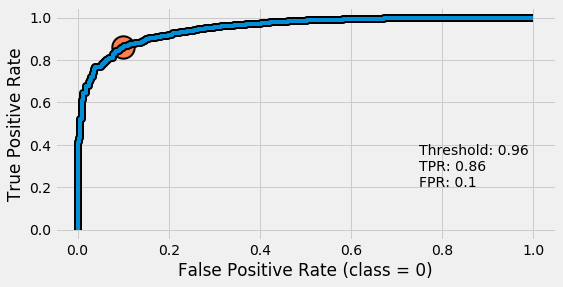

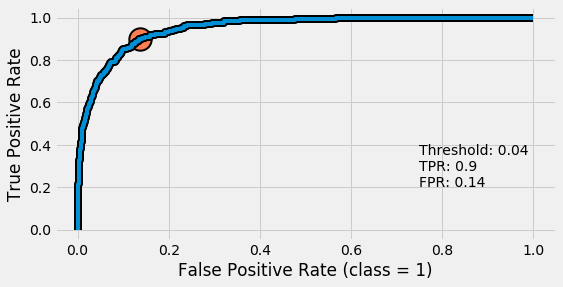

In [23]:
report = get_best_roc_threshold(model, Y)

La soglia che presenta il miglior trade-off fra *TPR* ed *FPR* sembra essere 0.04! Analizziamo i risultati di un *LDA* basato su questa threshold di classificazione:

In [24]:
threshold = 0.04

# Prendo la seconda colonna che è la probabilità della classe positiva
Y_prob = model.predict_proba(X)[:, 1]

Y_pred = np.where(Y_prob >= threshold, 1, 0)

In [25]:
pretty_cm(y_true = Y, y_pred = Y_pred, classes = model.classes_)

True            
                    0    1  Total
Predicted 0      8320   33   8353
          1      1347  300   1647
          Total  9667  333  10000

In [26]:
specificity = 1 - (1347/9667)

recall_score(y_true = Y, y_pred = Y_pred), specificity

(0.9009009009009009, 0.860659977242164)

In [27]:
zero_one_loss(y_true = Y, y_pred = Y_pred)

0.138

Abbiamo anche a disposizione l'*AUC Score*:

In [28]:
report[1]["auc"]

0.9495202246831501

---

<a id="qda"></a>
## Quadratic Discriminant Analysis

Seguendo gli stessi principi della *LDA*, la *QDA* assume che la distribuzione delle osservazioni per ogni classe abbia andamento normale, ma a differenza della *LDA* permette a ciascuna classe di avere una propria matrice di covarianza per i predittori.

Questo vuol dire che l'insieme dei predittori seguirà una *multivariate gaussian* distinta per ciascuna classe, con un proprio vettore di medie e delle intra-correlazioni tipiche della classe.

Di seguito riportiamo la modifica che subisce la formulazione della **discriminant function** dopo aver eliminato la matrice di covarianza unificata $\Sigma$ e aver abilitato le singole matrici $\Sigma_k$.

$$\large \delta_k(x)=-\frac{1}{2}(x-\mu_k)^T\Sigma_k^{-1}(x-\mu_k)
-\frac{1}{2}log|\Sigma_k|+log\pi_k$$

La *QDA*, quindi, calcola la *discriminant function* per ciascuna delle $K$ classi e assegna alla generica osservazione di test la classe che presenta il valore più grande per $\delta_k(x)$.

Notiamo, inoltre, che questa nuova *discriminant function* risulta essere una funzione **quadratica** dei predittori $x$, ed è infatti da qui che il *learning method* prende il suo nome.

Come possiamo scegliere fra *LDA* e *QDA*? La risposta va cercata, come spesso accade, nel *bias-variance trade-off*.

In presenza di $p$ predittori, stimare una matrice di covarianza vuol dire stimare $p(p+1)/2$ parametri. Se la *QDA* costruisce una matrice di covarianza per ciascuna classe, stiamo parlando di $Kp(p+1)/2$ parametri. Di conseguenza, la *LDA* è un classificatore molto meno flessibile della *QDA*, e presenta una varianza molto più bassa. C'è però un *trade-off*: se l'assunzione di variabilità condivisa delle classi, formulata dalla *LDA*, è particolarmente sbagliata, quest'ultima soffre di un altissimo valore di bias.

In parole povere, la *LDA* tende ad essere migliore della *QDA* se ci sono poche osservazioni, e quindi la riduzione della varianza è fondamentale. Al contrario, la *QDA* è preferibile quando il *training set* è molto ampio, perciò c'è meno pericolo di incorrere in *high variance* e, soprattutto, seguire un'assunzione che forza le variabilità delle classi ad essere uguale diventa impraticabile.

Nel plot a sinistra troviamo due classi i cui predittori presentano una correlazione (comune ad entrambe le classi) pari a 0.7. Il *bayes decision boundary* è lineare, ed è accuratamente approssimato dal *decision boundary* costruito dalla *LDA*. Il *decision boundary* costruito dalla *QDA*, invece, è inferiore, perché soffre di maggiore variabilità senza godere di una corrispondente decrescita di bias.

<img src="imgs/qda.PNG"></img>

Nel plot a destra, invece, abbiamo una classe arancione i cui predittori sono correlati a 0.7 e una classe blu i cui predittori sono correlati a -0.7. Il *bayes decision boundary* diventa quadratico, ed è la *QDA* a costruire il *decision boundary* che lo approssima meglio!

---

<a id="comparison"></a>
# A Comparison of Classification Methods

Sia la regressione logistica che la *LDA* producono *decision boundary* lineari. L'unica differenza fra i due approcci è che i coefficienti della prima sono stimati attraverso la *MLE*, mentre i coefficienti della seconda sono calcolati attraverso la media e varianza di un *sample* normale.

La *LDA* assume che le osservazioni siano estratte da una distirbuzione gaussiana con matrice di covarianza comune per tutte le classi, pertanto può evidenziare dei miglioramenti nei confronti della regressione logistica se tale assunzione risulta rispettata. Al contrario, è la regressione logistica a prevalere se le assunzioni normali non sono soddisfatte.

Il *KNN classifier*, invece, è un approccio totalmente non-parametrico: ci aspettiamo, quindi, che se il *vero decision boundary* è non lineare, esso dovrebbe comportarsi molto meglio rispetto alla *LDA* e alla regressione logistica. D'altro canto, però, il *KNN* non fornisce alcuna informazione sull'importanza dei predittori, che invece sono presenti nella tabella dei coefficienti della regressione logistica.

La *QDA*, invece, rappresenta una sorta di compromesso fra il *KNN* e i due approcci lineari, essendo in grado di costruire dei *decision boundary* quadratici. Pur non essendo così flessibile come il *KNN*, la *QDA* può risultare più accurata in presenza di un numero limitato di osservazioni di *training*, sfruttando a proprio vantaggio le assunzioni parametriche normali.

In realtà nessun metodo domina sull'altro in ogni contesto possibile. Se il *decision boundary* reale è lineare, allora la *LDA* e la regressione logistica tendono a classificare molto bene; quando il *decision boundary* è *moderatamente* non-lineare, la *QDA* può fornire i risultati migliori; quando, infine, il *decision boundary* è estremamente complicato, è il *KNN* il *learning method* che fornisce i risultati migliori.

Ricordiamo, infine, che in maniera simile a quanto visto per i *learning method* di regressione, è possibile facilitare la modellazione di relazioni non-lineari fra *predictors* e *response* applicando delle trasformazioni ai predittori.

Ad esempio, potremmo creare una versione più flessibile della regressione logistica inserendo $X^2,X^3,X^4$ come nuovi predittori fittizi. Potremmo fare lo stesso con la *LDA*, e il risultato sarebbe una sorta di compromesso intermedio fra *LDA* e *QDA*.

---

<a id="lab"></a>
# Lab

Carichiamo il dataset *Stock Market*:

In [29]:
sma = pd.read_csv("data/smarket.csv")
sma.drop(["Unnamed: 0"], axis = 1, inplace = True)
print(len(sma))
sma.head()

1250


,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


Ogni riga coincide con un diverso giorno dell'anno, e l'intera *time window* copre dal 2001 al 2005.

Per ogni giorno, si è tenuto traccia dei seguenti dati: la *percentage return* nella data in questione, la *percentage return* dei cinque giorni precedenti, il numero di azioni *tradate* il giorno precedente (in miliardi) e la direzione del mercato in tale giornata (*Up* o *Down*).

Analizziamo la correlazione fra le variabili:

In [30]:
sma.corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


Sembra esserci bassa correlazione fra *today* e i *lag*, come a voler dire che i ritorni passati non sono correlati ai ritorni del giorno attuale.

L'unica correlazione degna di nota è fra *year* e *volume*: vuol dire che il numero di azioni tradate è aumentato dal 2001 al 2005.

<br>

### Logistic Regression

In [31]:
df = sma.copy()
df["Direction"].replace({"Up": 1, "Down": 0}, inplace = True)

Y = df.Direction
X = df[["Lag1","Lag2","Lag3","Lag4","Lag5","Volume"]]
X = sm.add_constant(X)

model = sm.Logit(endog = Y, exog = X).fit()

model.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.691034
         Iterations 4


,coef,std err,z,P>|z|,[0.025,0.975]
const,-0.1260,0.241,-0.523,0.601,-0.598,0.346
Lag1,-0.0731,0.050,-1.457,0.145,-0.171,0.025
Lag2,-0.0423,0.050,-0.845,0.398,-0.140,0.056
Lag3,0.0111,0.050,0.222,0.824,-0.087,0.109
Lag4,0.0094,0.050,0.187,0.851,-0.089,0.107
Lag5,0.0103,0.050,0.208,0.835,-0.087,0.107
Volume,0.1354,0.158,0.855,0.392,-0.175,0.446


Il p-value più piccolo è associato a Lag1: il suo coefficiente negativo suggerisce che se il mercato ha avuto un ritorno positivo ieri, è meno probabile che vada su oggi. In ogni caso, il p-value è troppo grande e non c'è evidenza di una chiara associazione fra direction e lag1.

Costruiamo la **confusion matrix**:

In [32]:
Y_prob = model.predict(X)
Y_pred = np.where(Y_prob > 0.5, 1, 0)

Abbiamo 652 classificazioni corrette su 1250:

In [33]:
pretty_cm(y_true = Y, y_pred = Y_pred, classes = [0, 1])

True           
                   0    1 Total
Predicted 0      145  141   286
          1      457  507   964
          Total  602  648  1250

L'error rate è molto basso, siamo sotto al 50%:

In [34]:
zero_one_loss(y_true = Y, y_pred = Y_pred)

0.47840000000000005

Costruiamo un training set ed un test set isolando i dati sul 2005:

In [35]:
train = df[df.Year != 2005].copy()
test = df[df.Year == 2005].copy()

In [36]:
Y_train = train.Direction
X_train = train[["Lag1","Lag2","Lag3","Lag4","Lag5","Volume"]]
X_train = sm.add_constant(X_train)

model = sm.Logit(endog = Y_train, exog = X_train).fit()

model.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.691936
         Iterations 4


,coef,std err,z,P>|z|,[0.025,0.975]
const,0.1912,0.334,0.573,0.567,-0.463,0.845
Lag1,-0.0542,0.052,-1.046,0.295,-0.156,0.047
Lag2,-0.0458,0.052,-0.884,0.377,-0.147,0.056
Lag3,0.0072,0.052,0.139,0.889,-0.094,0.108
Lag4,0.0064,0.052,0.125,0.901,-0.095,0.108
Lag5,-0.0042,0.051,-0.083,0.934,-0.104,0.096
Volume,-0.1163,0.240,-0.485,0.628,-0.586,0.353


Adesso il modello performa peggio del random guessing sui dati di test!

In [37]:
Y_test = test.Direction
X_test = test[["Lag1","Lag2","Lag3","Lag4","Lag5","Volume"]]
X_test = sm.add_constant(X_test)

Y_prob = model.predict(X_test)
Y_pred = np.where(Y_prob > 0.5, 1, 0)

zero_one_loss(y_true = Y_test, y_pred = Y_pred)

0.5198412698412698

Probabilmente rimuovendo le variabili non utili a predire direction potremmo ottenere un modello più accurato. In fondo usare predittori che non hanno relazione con la response non fa altro che deteriorare il test error rate, dato che predittori del genere non portano altro che un aumento di varianza che non trova un corrispondente decremento di bias.

Proviamo usando solo lag1 e lag2:

In [38]:
Y_train = train.Direction
X_train = train[["Lag1","Lag2"]]
X_train = sm.add_constant(X_train)

model = sm.Logit(endog = Y_train, exog = X_train).fit()

model.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.692085
         Iterations 3


,coef,std err,z,P>|z|,[0.025,0.975]
const,0.0322,0.063,0.508,0.611,-0.092,0.156
Lag1,-0.0556,0.052,-1.076,0.282,-0.157,0.046
Lag2,-0.0445,0.052,-0.861,0.389,-0.146,0.057


Il modello migliora, azzecca il 56% delle previsioni, ma non è un granchè.

In [39]:
Y_test = test.Direction
X_test = test[["Lag1","Lag2"]]
X_test = sm.add_constant(X_test)

Y_prob = model.predict(X_test)
Y_pred = np.where(Y_prob > 0.5, 1, 0)

zero_one_loss(y_true = Y_test, y_pred = Y_pred)

0.44047619047619047

<br>

### LDA & QDA

Proviamo con una LDA usando solo Lag1 e Lag2:

In [40]:
Y_train = train.Direction
Y_test = test.Direction

X_train = train[["Lag1","Lag2"]]
X_test = test[["Lag1","Lag2"]]

model = LinearDiscriminantAnalysis(solver = "svd")
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

zero_one_loss(Y_test, Y_pred)

0.44047619047619047

Praticamente analogo alla regressione logistica!

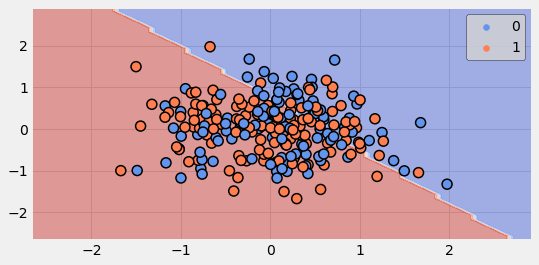

In [41]:
plot_2d_decbound(X1 = np.array(X_test)[:,0],
                 X2 = np.array(X_test)[:,1],
                 Y = Y_test,
                 model = model)

La QDA è corretta quasi il 60% delle volte!

In [42]:
Y_train = train.Direction
Y_test = test.Direction

X_train = train[["Lag1","Lag2"]]
X_test = test[["Lag1","Lag2"]]

model = QuadraticDiscriminantAnalysis()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

zero_one_loss(Y_test, Y_pred)

0.4007936507936508

<br>

### KNN Classifier

Proviamo con un KNN:

In [43]:
Y_train = train.Direction
Y_test = test.Direction

X_train = train[["Lag1","Lag2"]]
X_test = test[["Lag1","Lag2"]]

test_errors = list()

for k in range(1, 30):
    model = KNeighborsClassifier(n_neighbors = k)
    model.fit(X_train, Y_train)

    Y_pred = model.predict(X_test)
    test_errors.append(zero_one_loss(Y_test, Y_pred))

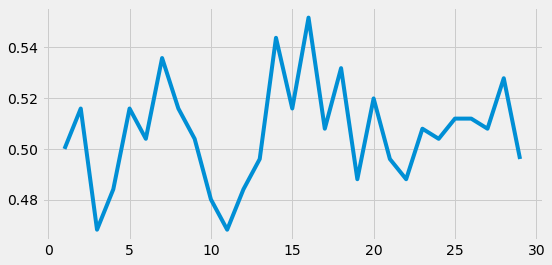

In [44]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(np.arange(1, 30), test_errors)
plt.show()

A prescindere dal valore di K, sembra performare peggio della QDA!

---

Carichiamo il dataset *Caravan*:

In [45]:
car = pd.read_csv("data/caravan.csv")
car.drop(["Unnamed: 0"], axis = 1, inplace = True)
car["Purchase"].replace({"Yes": 1, "No": 0}, inplace = True)
print(len(car))
car.head()

5822


,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,0


Ogni riga è un singolo individuo, a cui sono associati 85 predittori demografici. La response è Purchase, che indica se l'individuo ha acquistato una polizza assicurativa.

In questo dataset, solo il 6% degli individui hanno acquistato una polizza.

Standardizziamo i dati in modo da preparare un KNN con K unitario:

In [46]:
df = car.copy()
feature_names = [col for col in car.columns if col != "Purchase"]

X = df[feature_names].copy()
X = preprocessing.scale(X)
Y = df.Purchase

X_train = X[1000:,:]
Y_train = Y[1000:]
X_test = X[:1000,:]
Y_test = Y[:1000]

L'error rate è poco sotto il 12%, ma solo il 6% degli individui ha acquistato una polizza, quindi ci basterebbe sempre predire "No" per avere un test error addirittura inferiore!

In [47]:
model = KNeighborsClassifier(n_neighbors = 1)
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

zero_one_loss(Y_test, Y_pred)

0.118

In realtà dalla confusion matrix notiamo che 9 acquirenti su 77 sono stati predetti correttamente; si tratta dell'11.7%, quindi è quasi il doppio del rate di classificazioni corrette che otterremmo con il random guessing!

In [48]:
pretty_cm(np.array(Y_test), Y_pred, classes = [0, 1])

True          
                   0   1 Total
Predicted 0      873  50   923
          1       68   9    77
          Total  941  59  1000

Proviamo con K = 5:

In [49]:
model = KNeighborsClassifier(n_neighbors = 5)
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

zero_one_loss(Y_test, Y_pred)

0.06599999999999995

In [50]:
pretty_cm(np.array(Y_test), Y_pred, classes = [0, 1])

True          
                   0   1 Total
Predicted 0      930  55   985
          1       11   4    15
          Total  941  59  1000

Saliamo a oltre il 25% in precision!

<br>

Proviamo con una regressione logistica con soglia non standard, cioè 0.25 al posto di 0.50.

In [51]:
model = LogisticRegression(solver = "newton-cg")
model.fit(X_train, Y_train)

threshold = 0.25

# Prendo la seconda colonna che è la probabilità della classe positiva
Y_prob = model.predict_proba(X_test)[:, 1]

Y_pred = np.where(Y_prob > threshold, 1, 0)

zero_one_loss(Y_test, Y_pred)

0.07199999999999995

In [52]:
pretty_cm(Y_test, Y_pred, classes = model.classes_)

True          
                   0   1 Total
Predicted 0      917  48   965
          1       24  11    35
          Total  941  59  1000

La precision ora supera il 30%!

---

Carichiamo il dataset *Weekly*:

In [53]:
wek = pd.read_csv("data/weekly.csv")
wek["Direction"].replace({"Up": 1, "Down": 0}, inplace = True)
wek.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,0
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,0
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,1
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,1
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,1


E' un dataset simile a Smarket, ma contiene 1089 ritorni dal 1990 al 2010.

In [54]:
wek.corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
Year,1.000000,-0.032289,-0.033390,-0.030006,-0.031128,-0.030519,0.841942,-0.032460,-0.022200
Lag1,-0.032289,1.000000,-0.074853,0.058636,-0.071274,-0.008183,-0.064951,-0.075032,-0.050004
Lag2,-0.033390,-0.074853,1.000000,-0.075721,0.058382,-0.072499,-0.085513,0.059167,0.072696
Lag3,-0.030006,0.058636,-0.075721,1.000000,-0.075396,0.060657,-0.069288,-0.071244,-0.022913
Lag4,-0.031128,-0.071274,0.058382,-0.075396,1.000000,-0.075675,-0.061075,-0.007826,-0.020549
Lag5,-0.030519,-0.008183,-0.072499,0.060657,-0.075675,1.000000,-0.058517,0.011013,-0.018168
Volume,0.841942,-0.064951,-0.085513,-0.069288,-0.061075,-0.058517,1.000000,-0.033078,-0.017995
Today,-0.032460,-0.075032,0.059167,-0.071244,-0.007826,0.011013,-0.033078,1.000000,0.720025
Direction,-0.022200,-0.050004,0.072696,-0.022913,-0.020549,-0.018168,-0.017995,0.720025,1.000000


L'unica relazione importante sembra essere quella fra Year e Volume: col passare degli anni aumentano le azioni tradate.

Addestriamo una regressione logistica usando i Lag e il Volume:

In [55]:
Y = wek.Direction
X = wek[["Lag1","Lag2","Lag3","Lag4","Lag5","Volume"]]
X = sm.add_constant(X)

model = sm.Logit(endog = Y, exog = X).fit()

model.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.682441
         Iterations 4


,coef,std err,z,P>|z|,[0.025,0.975]
const,0.2669,0.086,3.106,0.002,0.098,0.435
Lag1,-0.0413,0.026,-1.563,0.118,-0.093,0.010
Lag2,0.0584,0.027,2.175,0.030,0.006,0.111
Lag3,-0.0161,0.027,-0.602,0.547,-0.068,0.036
Lag4,-0.0278,0.026,-1.050,0.294,-0.080,0.024
Lag5,-0.0145,0.026,-0.549,0.583,-0.066,0.037
Volume,-0.0227,0.037,-0.616,0.538,-0.095,0.050


Solo Lag2 sembra essere un predittore significativo.

In [56]:
Y_prob = model.predict(X)
Y_pred = np.where(Y_prob > 0.5, 1, 0)

print(zero_one_loss(Y, Y_pred))
pretty_cm(Y, Y_pred, classes = [0, 1])

0.43893480257116624


True           
                   0    1 Total
Predicted 0       54   48   102
          1      430  557   987
          Total  484  605  1089

Il modello sbaglia poco di meno rispetto al random guessing. 

In [57]:
rates(Y, Y_pred, classes = [0, 1])

,0,1
TPR - Sensitivity,0.11157,0.920661
TNR - Specificity,0.920661,0.11157
FPR - Fallout,0.0793388,0.88843
FNR - Miss Rate,0.88843,0.0793388


In [58]:
classif_report(y_true = Y, y_pred = Y_pred,
               classes = [0, 1], names = ["0", "1"], df_out = False)

'              precision    recall  f1-score   support\n\n           0       0.53      0.11      0.18       484\n           1       0.56      0.92      0.70       605\n\n    accuracy                           0.56      1089\n   macro avg       0.55      0.52      0.44      1089\nweighted avg       0.55      0.56      0.47      1089\n'

<br>

Creiamo un training set ed un test set isolando i dati fino al 2008 compreso per il training e dal 2009 in poi per il test.

In [59]:
train = wek[wek.Year <= 2008].copy()
test = wek[wek.Year > 2008].copy()

Addestriamo una regressione logistica usando solo Lag2 come predittore:

In [60]:
Y_train = train.Direction
Y_test = test.Direction

X_train = train[["Lag2"]]
X_test = test[["Lag2"]]
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

model = sm.Logit(endog = Y_train, exog = X_train).fit()

model.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.685555
         Iterations 4


,coef,std err,z,P>|z|,[0.025,0.975]
const,0.2033,0.064,3.162,0.002,0.077,0.329
Lag2,0.0581,0.029,2.024,0.043,0.002,0.114


In [61]:
Y_prob = model.predict(X_test)
Y_pred = np.where(Y_prob > 0.5, 1, 0)

print(zero_one_loss(Y_test, Y_pred))
pretty_cm(Y_test, Y_pred, classes = [0, 1])

0.375


True          
                   0   1 Total
Predicted 0        9   5    14
          1       34  56    90
          Total   43  61   104

<br>

Proviamo con LDA, QDA e KNN:

In [62]:
Y_train = train.Direction
Y_test = test.Direction

X_train = train[["Lag2"]]
X_test = test[["Lag2"]]

In [63]:
model = LinearDiscriminantAnalysis(solver = "svd")
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

print(zero_one_loss(Y_test, Y_pred))
pretty_cm(y_true = Y_test, y_pred = Y_pred, classes = model.classes_)

0.375


True          
                   0   1 Total
Predicted 0        9   5    14
          1       34  56    90
          Total   43  61   104

La LDA è identica alla regressione logistica in questo caso.

In [64]:
model = QuadraticDiscriminantAnalysis()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

print(zero_one_loss(Y_test, Y_pred))
pretty_cm(y_true = Y_test, y_pred = Y_pred, classes = model.classes_)

0.41346153846153844


True          
                   0   1 Total
Predicted 0        0   0     0
          1       43  61   104
          Total   43  61   104

La QDA va peggio, e addirittura predice solo valori "Up" per Direction!

In [65]:
model = KNeighborsClassifier(n_neighbors = 1)
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

print(zero_one_loss(Y_test, Y_pred))
pretty_cm(y_true = Y_test, y_pred = Y_pred, classes = model.classes_)

0.5096153846153846


True          
                   0   1 Total
Predicted 0       21  31    52
          1       22  30    52
          Total   43  61   104

Sembra che il miglior risultato sia ottenuto da LDA e regressione logistica!

---